In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.interpolate import make_interp_spline
from tqdm import tqdm # for showing progress bar in for loops
from scipy.stats import pearsonr
from causal_ccm.causal_ccm import ccm
import warnings
warnings.filterwarnings("ignore")
from nolitsa import dimension, delay
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.preprocessing import MinMaxScaler
from pyEDM import *
from matplotlib import font_manager
import matplotlib.font_manager as fm
import matplotlib as mpl
from cycler import cycler
from sklearn.ensemble import GradientBoostingRegressor
import shap
from itertools import combinations
import warnings

In [2]:
#Define plotting style
montserrat_path = "./Montserrat/static"
font_files = font_manager.findSystemFonts(fontpaths=montserrat_path)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

mpl.rcParams.update({
    'font.family': 'Montserrat',
    'font.size': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.minor.size': 1,
    'ytick.minor.size': 1,
    'grid.alpha': 0.5,
    'axes.grid': True,
    'grid.linewidth': 2,
    'axes.grid.which': 'both',
    'axes.titleweight': 'bold',
    'axes.titlesize': 18,
    'axes.prop_cycle': cycler('color', ['#3cd184', '#f97171', '#1e81b0', '#66beb2', '#f99192', '#8ad6cc', '#3d6647', '#000080']),
    'image.cmap': 'viridis',
})

In [3]:
#Load the data
df = pd.read_csv('New pm dataset.csv',parse_dates=['dateTime'])
#Remove extra columns
columns_to_remove = [ 'pm1_grimm']
df = df.drop(columns=columns_to_remove)
# Rename columns
new_column_names = {
    'dateTime': 'dateTime',
    'pm2_5_grimm': 'PM2.5',
    'binCount0_OPCN3': 'Bin 0',
    'binCount1_OPCN3': 'Bin 1',
    'binCount2_OPCN3': 'Bin 2',
    'binCount3_OPCN3': 'Bin 3',
    'binCount4_OPCN3': 'Bin 4',
    'binCount5_OPCN3': 'Bin 5',
    'binCount6_OPCN3': 'Bin 6',
    'binCount7_OPCN3': 'Bin 7',
    'binCount8_OPCN3': 'Bin 8',
    'binCount9_OPCN3': 'Bin 9',
    'binCount10_OPCN3': 'Bin 10',
    'binCount11_OPCN3': 'Bin 11',
    'binCount12_OPCN3': 'Bin 12',
    'binCount13_OPCN3': 'Bin 13',
    'binCount14_OPCN3': 'Bin 14',
    'binCount15_OPCN3': 'Bin 15',
    'binCount16_OPCN3': 'Bin 16',
    'binCount17_OPCN3': 'Bin 17',
    'binCount18_OPCN3': 'Bin 18',
    'binCount19_OPCN3': 'Bin 19',
    'binCount20_OPCN3': 'Bin 20',
    'binCount21_OPCN3': 'Bin 21',
    'binCount22_OPCN3': 'Bin 22',
    'binCount23_OPCN3': 'Bin 23',
    'bin1TimeToCross_OPCN3': 'Bin 1 Time to Cross',
    'bin3TimeToCross_OPCN3': 'Bin 3 Time to Cross',
    'bin5TimeToCross_OPCN3': 'Bin 5 Time to Cross',
    'bin7TimeToCross_OPCN3': 'Bin 7 Time to Cross',
    'sampleFlowRate_OPCN3': 'Sample Flow Rate',
    'temperature_OPCN3': 'OPCN3 Interior Temperature',
    'humidity_OPCN3': 'OPCN3 Interior Humidity',
    'pm1_OPCN3': 'PM1 from OPCN3',
    'pm2_5_OPCN3': 'PM2.5 from OPCN3',
    'pm10_OPCN3': 'PM10 from OPCN3',
    'rejectCountGlitch_OPCN3': 'Reject Count Glitch',
    'rejectCountLongTOF_OPCN3': 'Reject Count Long TOF',
    'rejectCountRatio_OPCN3': 'Reject Count Ratio',
    'rejectCountOutOfRange_OPCN3': 'Reject Count Out Of Range',
    'temperature_BME280_centralNodeRetime': 'Ambient Temperature',
    'pressure_BME280_centralNodeRetime': 'Ambient Pressure',
    'humidity_BME280_centralNodeRetime': 'Ambient Humidity',
    'altitude_BME280_centralNodeRetime': 'Altitude'
}

df.rename(columns=new_column_names, inplace=True)
df.set_index('dateTime', inplace=True)

In [4]:
#Resample data at 60S frequency 
df = df.resample('60S').mean()
df= df.reset_index(drop=False)

#Isolate data instances for causal analysis and validation
df1 = df[df['dateTime'].dt.date == pd.to_datetime('2019-04-05').date()]
df2 = df[df['dateTime'].dt.date == pd.to_datetime('2019-04-06').date()]
df3 = df[df['dateTime'].dt.date == pd.to_datetime('2019-04-07').date()]

df01=df1[60:770]
df02=df2[60:770]
df03=df3[60:770]

#Drop NaNs
df01 = df01.dropna(axis=0, how='any')
df02 = df02.dropna(axis=0, how='any')
df03 = df03.dropna(axis=0, how='any')

df_combined = pd.concat([df01, df02, df03], ignore_index=True)

#Isolate data for training and testing such that it does not include data used for causal analysis
dates_to_exclude = ['2019-04-05', '2019-04-06', '2019-04-07']
df_filtered = df[~df['dateTime'].dt.strftime('%Y-%m-%d').isin(dates_to_exclude)]
df_filtered = df_filtered.dropna(axis=0, how='any')


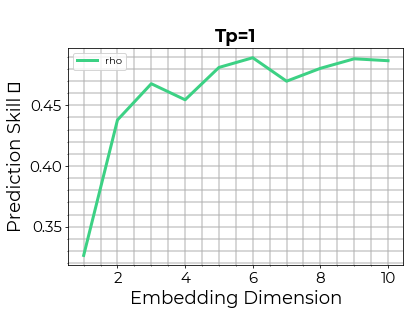

In [5]:
#Determine embedding dimension usingg simplex projection
EmbedDimension( dataFrame = df01, lib = "1 100", pred = "201 500", 
                columns = "PM2.5" );

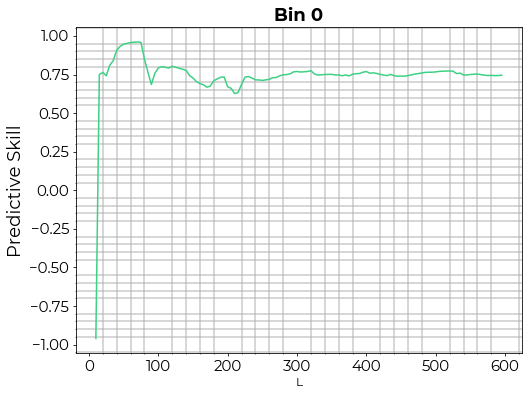

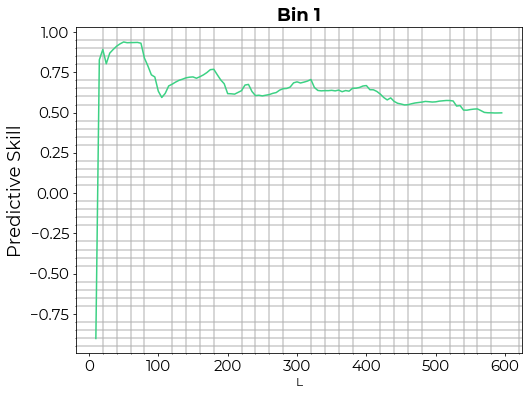

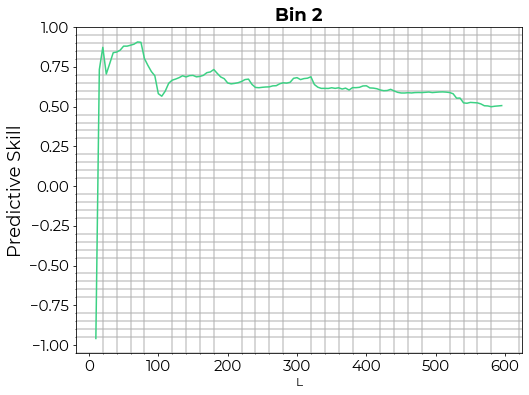

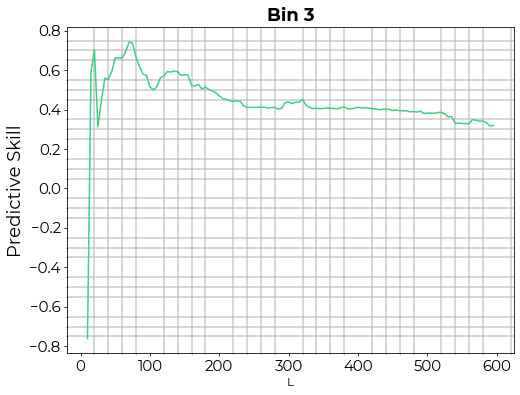

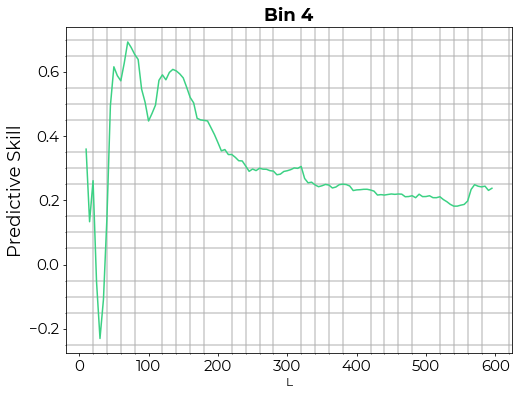

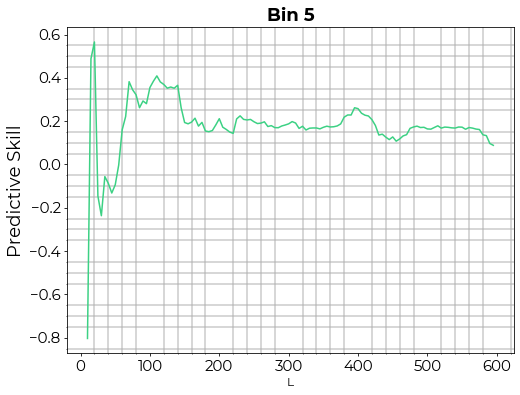

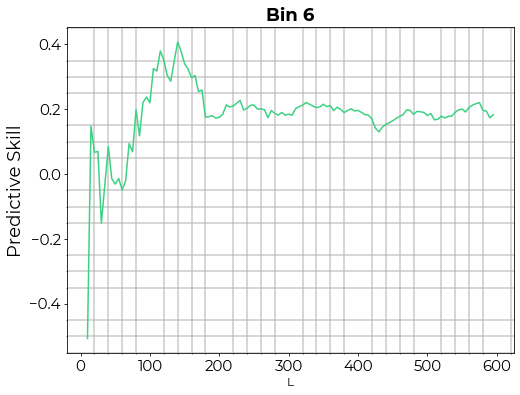

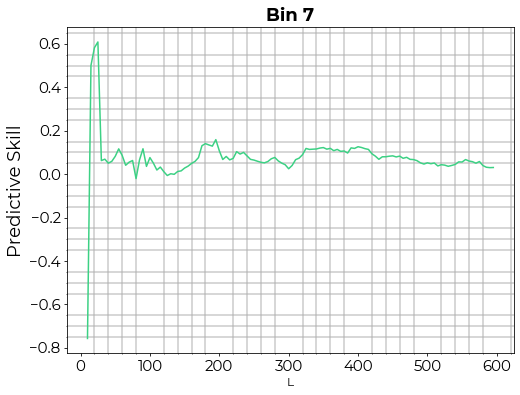

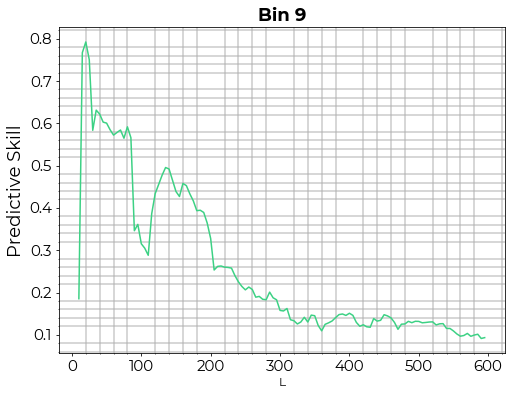

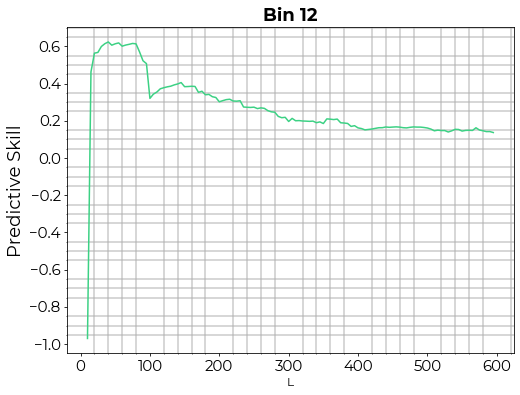

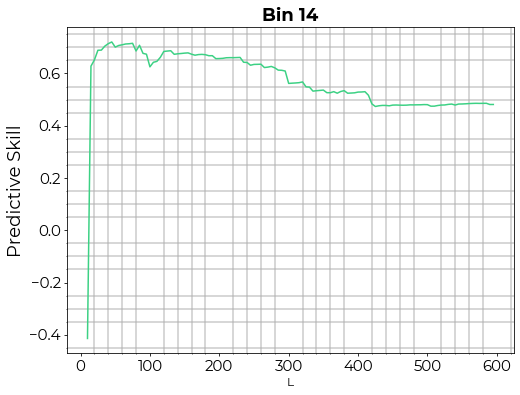

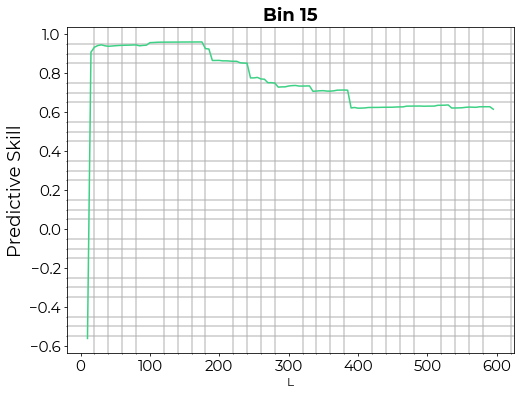

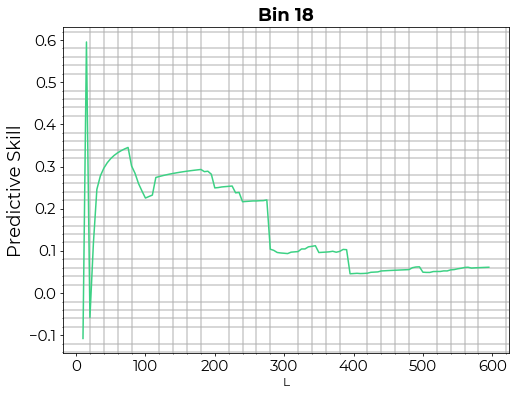

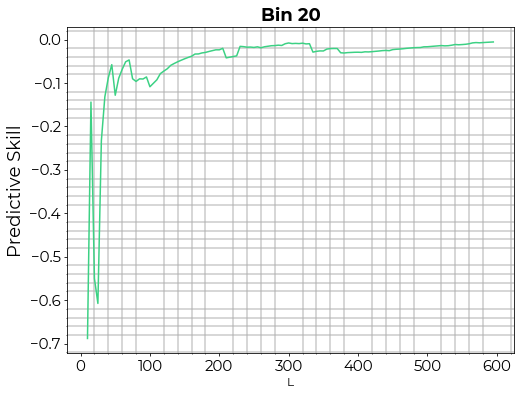

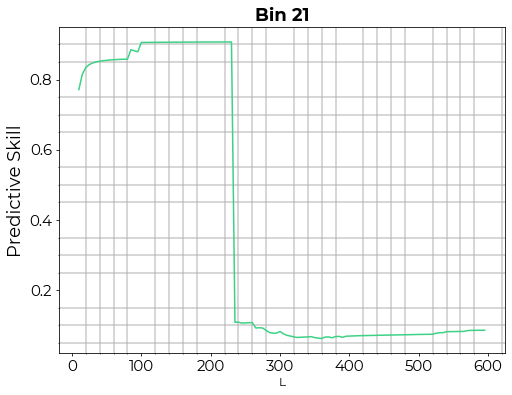

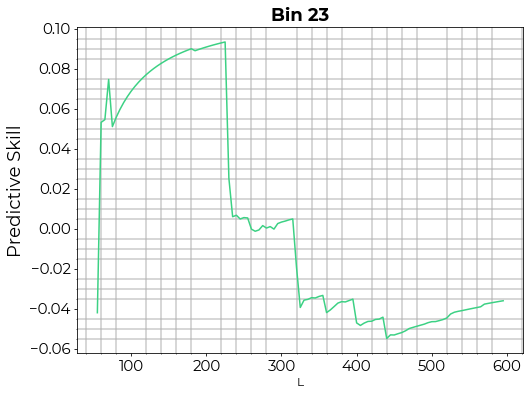

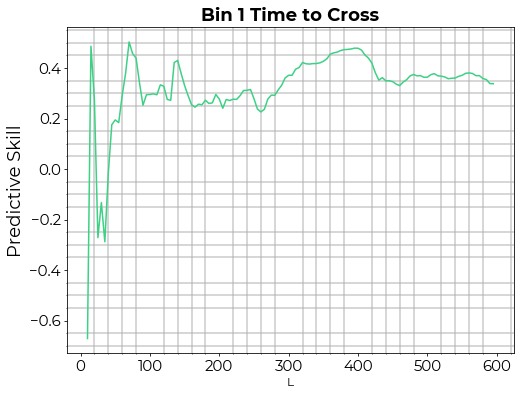

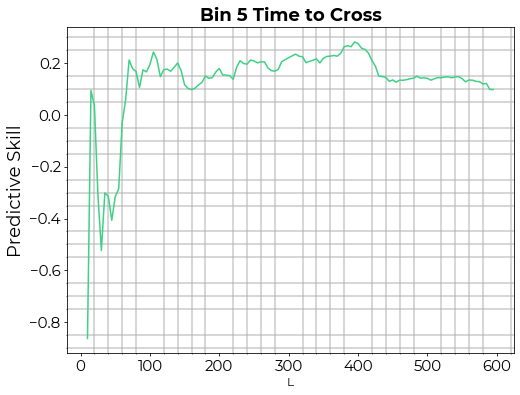

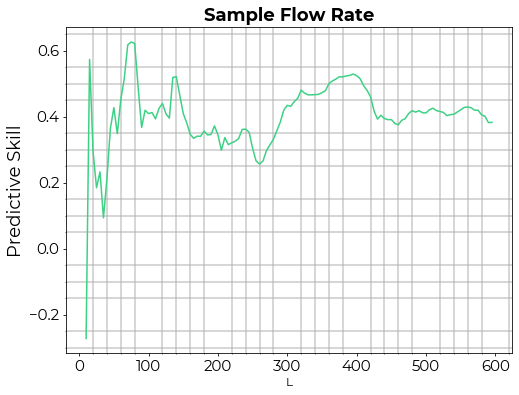

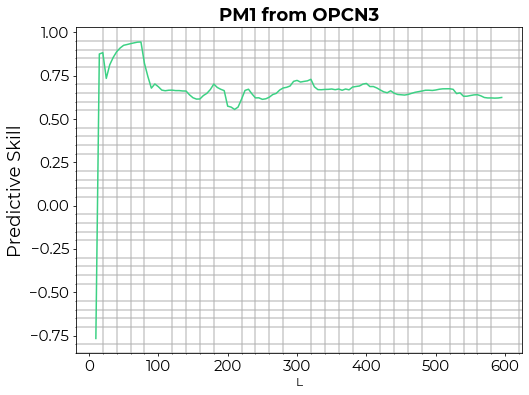

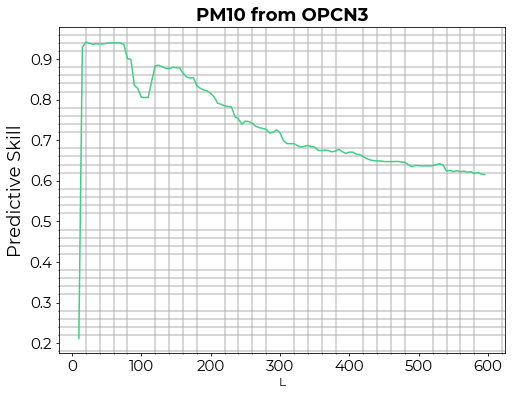

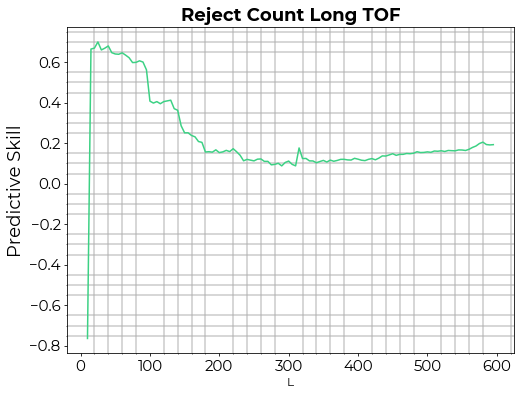

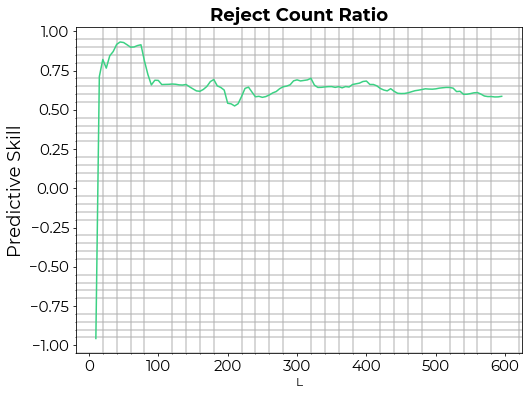

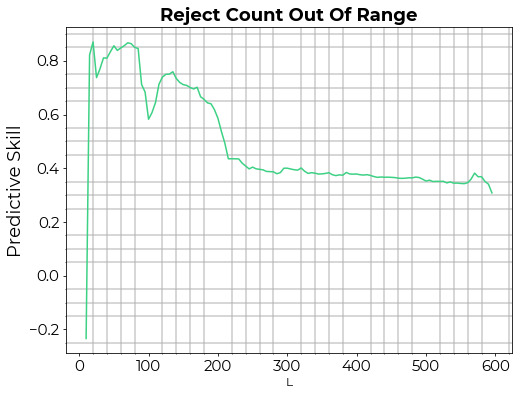

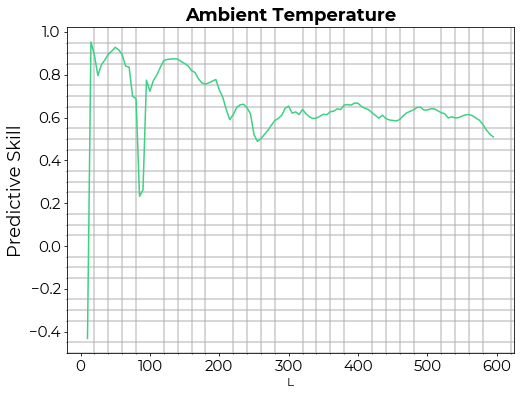

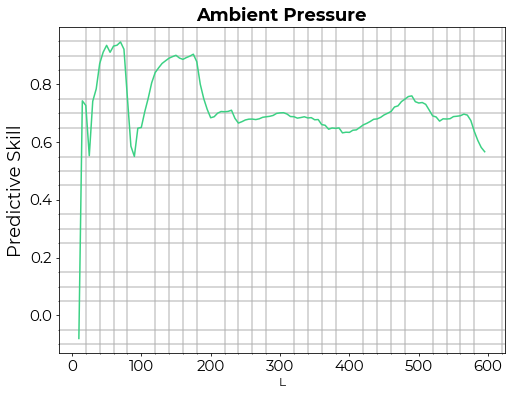

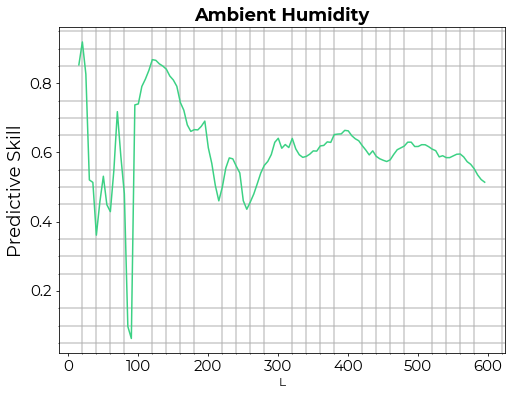

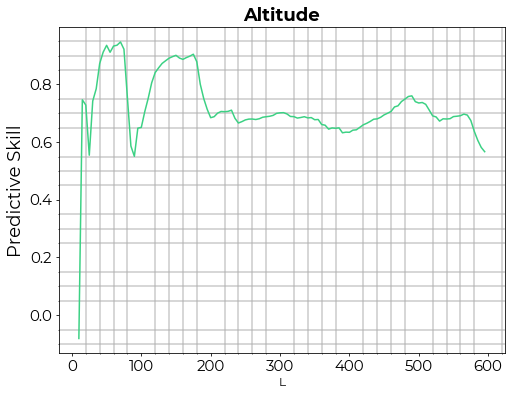

In [6]:
#Evaluate CCM criteria for causation

causality_XY_results = []  # Causality values for X -> Y
p_values_XY_results = []   # P-values for X -> Y
columns_list = []          # To store the column names


columns = ['Bin 0', 'Bin 1', 'Bin 2', 'Bin 3', 'Bin 4',
       'Bin 5', 'Bin 6', 'Bin 7', 'Bin 8', 'Bin 9', 'Bin 10', 'Bin 11',
       'Bin 12', 'Bin 13', 'Bin 14', 'Bin 15', 'Bin 16', 'Bin 17', 'Bin 18',
       'Bin 19', 'Bin 20', 'Bin 21', 'Bin 22', 'Bin 23', 'Bin 1 Time to Cross',
       'Bin 3 Time to Cross', 'Bin 5 Time to Cross', 'Bin 7 Time to Cross',
       'Sample Flow Rate', 'OPCN3 Interior Temperature',
       'OPCN3 Interior Humidity', 'PM1 from OPCN3', 'PM2.5 from OPCN3',
       'PM10 from OPCN3', 'Reject Count Glitch', 'Reject Count Long TOF',
       'Reject Count Ratio', 'Reject Count Out Of Range',
       'Ambient Temperature', 'Ambient Pressure', 'Ambient Humidity',
       'Altitude']

Y = df01['PM2.5'].values

L_range = range(10, 600, 5)  # Time steps to evaluate at
tau = 1 #Time lag for SSR
E = 6 #Embedding dimension for SSR

for col in columns:
    X = df01[col].values

    
    Xhat_My, Yhat_Mx = [], []
    p_values_XY, p_values_YX = [], []

    for L in L_range:
        ccm_XY = ccm(X, Y, tau, E, L)  
        ccm_YX = ccm(Y, X, tau, E, L)     

        Xhat_My.append(ccm_XY.causality()[0]) 
        Yhat_Mx.append(ccm_YX.causality()[0])
        
        
        p_values_XY.append(ccm_XY.causality()[1])
        p_values_YX.append(ccm_YX.causality()[1])

    
    causality_XY_results.append(Xhat_My[-1])  # X -> Y
    p_values_XY_results.append(p_values_XY[-1])  # p-value X -> Y
    columns_list.append(col)


    # Plots to display convergence
    plt.figure(figsize=(8, 6))
    plt.plot(L_range, Xhat_My)
    plt.xlabel('L', size=12)
    plt.ylabel('Predictive Skill')
    plt.title(f'{col}')
    plt.grid(False)
    plt.show()

df_causality_resultsPM25 = pd.DataFrame({
    'columns': columns_list,
    'causality_XY_results': causality_XY_results,
    'p_values_XY_results': p_values_XY_results
})

df_causality_resultsPM25.to_csv('causalityResultsPM25.csv')

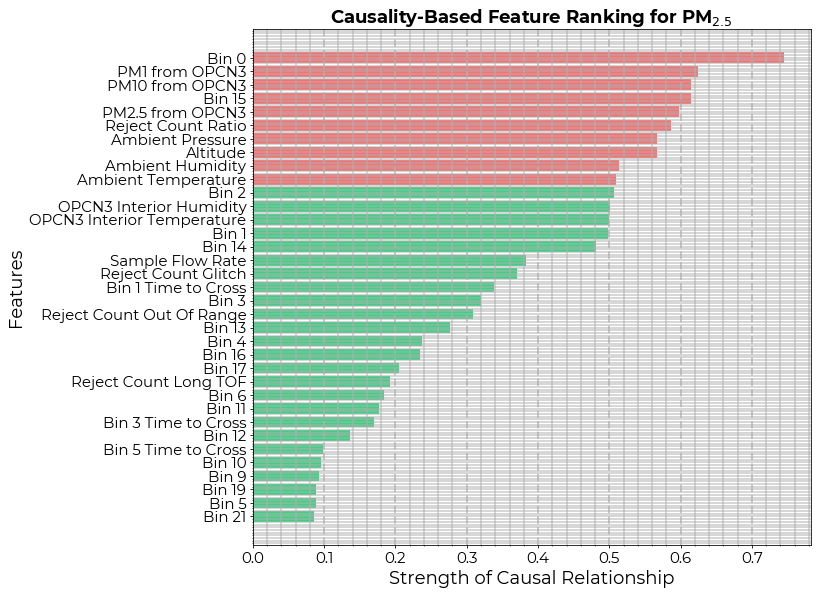

In [7]:
#Filter out features with p-value>=0.05
df_causality_resultsPM25 = df_causality_resultsPM25[df_causality_resultsPM25['p_values_XY_results'] < 0.05]

#Establish the ranking of the features acording to strength of causal influence
df_causality_resultsPM25 = df_causality_resultsPM25.sort_values(by='causality_XY_results', ascending=False)

colors = ['#f97171' if value >= 0.509 else '#3cd184' for value in df_causality_resultsPM25['causality_XY_results']]

plt.figure(figsize=(10, 9.5))
plt.barh(df_causality_resultsPM25['columns'], df_causality_resultsPM25['causality_XY_results'], color=colors)
plt.xlabel('Strength of Causal Relationship')
plt.ylabel('Features')
plt.title('Causality-Based Feature Ranking for PM$_{2.5}$')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.savefig('4.png', format='png',dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#Construct machine learning models for all possible subsets of the features above the set threshold and generate performance metrics for each instance

warnings.filterwarnings('ignore')

# Features exceeding the set threshold
features = [
    'Bin 0', 'PM1 from OPCN3',
    'PM10 from OPCN3','Bin 15', 'PM2.5 from OPCN3',
    'Reject Count Ratio','Ambient Pressure', 'Altitude',
    'Ambient Humidity','Ambient Temperature'
      
       ]

results_list = []

y_combined = df_combined['PM2.5']
y_filtered = df_filtered['PM2.5']

# Loop over all combinations of features
for r in range(1, len(features) + 1):
    for subset in combinations(features, r):
        print(f"Evaluating combination: {subset}")

        
        X_combined = df_combined[list(subset)]
        X_filtered = df_filtered[list(subset)]

        
        X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
            X_combined, y_combined, test_size=0.2, random_state=42
        )

        # Hyperparameter optimization 
        param_grid = {
            'n_estimators': [50,100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3,4,5],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }

        gbr = GradientBoostingRegressor(random_state=42)
        grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_combined, y_train_combined)

        # Get the best model
        best_gbr = grid_search.best_estimator_

        # Split the filtered dataset
        X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
            X_filtered, y_filtered, test_size=0.2, random_state=42
        )

        # Train the model with the best parameters on df_filtered
        best_gbr.fit(X_train_filtered, y_train_filtered)

        # Evaluate the model
        y_pred_train = best_gbr.predict(X_train_filtered)
        y_pred_test = best_gbr.predict(X_test_filtered)

        
        mse_test = mean_squared_error(y_test_filtered, y_pred_test)
        r2_test = r2_score(y_test_filtered, y_pred_test)

        
        results_list.append({
            'Combination': subset,
            'MSE_Test': mse_test,
            'R2_Test': r2_test
        })

# Create DataFrame at the end
CausalityFinalResults = pd.DataFrame(results_list)

# Save results to a CSV file if needed
CausalityFinalResults.to_csv('CausalityFinalResultsPM25.csv', index=False)


Evaluating combination: ('binCount0_OPCN3',)


In [8]:
#Choose the model that demonstrates the best predictive performance 
temp_df = pd.read_csv('CausalityFinalResultsPM25.csv')
# Entry with the smallest value for the 'MSE_Test' column
min_mse_entry = temp_df.loc[temp_df['MSE_Test'].idxmin()]
#causally selected set of features
min_mse_entry.Combination
# Print the row with the smallest MSE_Test
print(min_mse_entry)


Combination    ('binCount0_OPCN3', 'pm1_OPCN3', 'pm2_5_OPCN3'...
MSE_Test                                                0.273986
R2_Test                                                 0.984904
Name: 913, dtype: object


/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: F

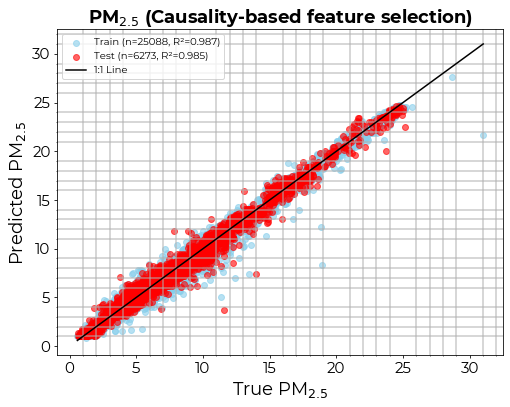

In [9]:
# Generate scatter plot

features = [
       'Bin 0','PM1 from OPCN3', 'PM2.5 from OPCN3','Reject Count Ratio',
       'Ambient Temperature', 'Ambient Pressure', 'Ambient Humidity'
        
       ]
# Hyperparameter optimization with GridSearchCV using the validation data set
X = df_combined[features]
y = df_combined['PM2.5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [ 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
    
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_gbr = grid_search.best_estimator_


#Train the hyperparameter optimized model on the training set and evaluate performance metrics on the test set
df_filtered = df_filtered.dropna(axis=0, how='any')
X = df_filtered[features]
y = df_filtered['PM2.5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_gbr.fit(X_train, y_train)
               

y_pred_train = best_gbr.predict(X_train)
y_pred_test_caus = best_gbr.predict(X_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test_caus)
plt.figure(figsize=(8, 6))

# Scatter plot for training data (baby blue)
plt.scatter(y_train, y_pred_train, color='skyblue', label=f'Train (n={len(y_train)}, R²={r2_train:.3f})', alpha=0.6)

# Scatter plot for test data (red)
plt.scatter(y_test, y_pred_test_caus, color='red', label=f'Test (n={len(y_test)}, R²={r2_test:.3f})', alpha=0.6)

# Plot the 1:1 line (black)
min_val = min(y.min(), y_pred_train.min(), y_pred_test_caus.min())
max_val = max(y.max(), y_pred_train.max(), y_pred_test_caus.max())
plt.plot([min_val, max_val], [min_val, max_val], color='black',  label='1:1 Line')

# Add labels and title
plt.xlabel('True PM$_{2.5}$')
plt.ylabel('Predicted PM$_{2.5}$')
plt.title('PM$_{2.5}$ (Causality-based feature selection)')

# Add legend
plt.legend(prop={'size': 10})
plt.grid(False)
# Show the plot
plt.show()


Comparison with all feature-model and SHAP-based feature selection


/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: F

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 100}
Mean Squared Error for Test Set: 0.4097517276682455
R^2 Score for Test Set: 0.9774240628437446


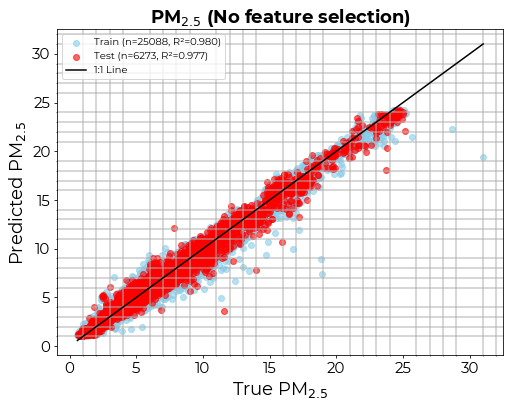

In [10]:
#Construct the calibration model with all features as predictors and generate SHAP-values and performance metrics

features = [
       'Bin 0', 'Bin 1', 'Bin 2', 'Bin 3', 'Bin 4',
       'Bin 5', 'Bin 6', 'Bin 7', 'Bin 8', 'Bin 9', 'Bin 10', 'Bin 11',
       'Bin 12', 'Bin 13', 'Bin 14', 'Bin 15', 'Bin 16', 'Bin 17', 'Bin 18',
       'Bin 19', 'Bin 20', 'Bin 21', 'Bin 22', 'Bin 23', 'Bin 1 Time to Cross',
       'Bin 3 Time to Cross', 'Bin 5 Time to Cross', 'Bin 7 Time to Cross',
       'Sample Flow Rate', 'OPCN3 Interior Temperature',
       'OPCN3 Interior Humidity', 'PM1 from OPCN3', 'PM2.5 from OPCN3',
       'PM10 from OPCN3', 'Reject Count Glitch', 'Reject Count Long TOF',
       'Reject Count Ratio', 'Reject Count Out Of Range',
       'Ambient Temperature', 'Ambient Pressure', 'Ambient Humidity',
       'Altitude'
        
       ]
# Hyperparameter optimization with GridSearchCV using the validation data set
X = df_combined[features]
y = df_combined['PM2.5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [ 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
    
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_gbr = grid_search.best_estimator_


#Train the hyperparameter optimized model on the training set and evaluate performance metrics on the test set
df_filtered = df_filtered.dropna(axis=0, how='any')
X = df_filtered[features]
y = df_filtered['PM2.5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_gbr.fit(X_train, y_train)

#Evaluate SHAP values
explainer = shap.Explainer(best_gbr, X_train)  
shap_values = explainer(X_train,check_additivity=False)               

y_pred_train = best_gbr.predict(X_train)
y_pred_test_full = best_gbr.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test_full)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test_full)


print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error for Test Set: {mse_test}")
print(f"R^2 Score for Test Set: {r2_test}")

plt.figure(figsize=(8, 6))

# Scatter plot for training data (baby blue)
plt.scatter(y_train, y_pred_train, color='skyblue', label=f'Train (n={len(y_train)}, R²={r2_train:.3f})', alpha=0.6)

# Scatter plot for test data (red)
plt.scatter(y_test, y_pred_test_full, color='red', label=f'Test (n={len(y_test)}, R²={r2_test:.3f})', alpha=0.6)

# Plot the 1:1 line (black)
min_val = min(y.min(), y_pred_train.min(), y_pred_test_full.min())
max_val = max(y.max(), y_pred_train.max(), y_pred_test_full.max())
plt.plot([min_val, max_val], [min_val, max_val], color='black',  label='1:1 Line')

# Add labels and title
plt.xlabel('True PM$_{2.5}$')
plt.ylabel('Predicted PM$_{2.5}$')
plt.title('PM$_{2.5}$ (No feature selection)')

# Add legend
plt.legend(prop={'size': 10})
plt.grid(False)
# Show the plot
plt.show()

In [11]:
#Establish the SHAP based feature ranking

shap_df = pd.DataFrame(shap_values.values, columns=features)
shap_importance = shap_df.abs().mean().sort_values(ascending=False)

top_10_features = shap_importance.index[:10]

plt.figure(figsize=(10, 9.5))
bar_colors = ['#f97171' if feature in top_10_features else '#3cd184' for feature in shap_importance.index]
plt.barh(shap_importance.index, shap_importance.values, color=bar_colors)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1.5)
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.title('SHAP Value-Based Feature Ranking for PM$_{2.5}$')
plt.gca().invert_yaxis()
plt.savefig('3.png', format='png',dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#Construct machine learning models for all possible subsets of the features with the top 10 SHAP scores  and generate performance metrics for each instance

warnings.filterwarnings('ignore')

# Features exceeding the set threshold
features = [
    'Bin 0', 'Reject Count Ratio','Reject Count Glitch',
    'PM1 from OPCN3','PM2.5 from OPCN3','Bin 3','OPCN3 Interior Temperature', 'OPCN3 Interior Humidity',
    'Bin 1','PM10 from OPCN3'
      ]

results_list = []

y_combined = df_combined['PM2.5']
y_filtered = df_filtered['PM2.5']

# Loop over all combinations of features
for r in range(1, len(features) + 1):
    for subset in combinations(features, r):
        print(f"Evaluating combination: {subset}")

        
        X_combined = df_combined[list(subset)]
        X_filtered = df_filtered[list(subset)]

        
        X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
            X_combined, y_combined, test_size=0.2, random_state=42
        )

        # Hyperparameter optimization 
        param_grid = {
            'n_estimators': [50,100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3,4,5],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }

        gbr = GradientBoostingRegressor(random_state=42)
        grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_combined, y_train_combined)

        # Get the best model
        best_gbr = grid_search.best_estimator_

        # Split the filtered dataset
        X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
            X_filtered, y_filtered, test_size=0.2, random_state=42
        )

        # Train the model with the best parameters on df_filtered
        best_gbr.fit(X_train_filtered, y_train_filtered)

        # Evaluate the model
        y_pred_train = best_gbr.predict(X_train_filtered)
        y_pred_test = best_gbr.predict(X_test_filtered)

        
        mse_test = mean_squared_error(y_test_filtered, y_pred_test)
        r2_test = r2_score(y_test_filtered, y_pred_test)

        
        results_list.append({
            'Combination': subset,
            'MSE_Test': mse_test,
            'R2_Test': r2_test
        })

# Create DataFrame at the end
SHAPFinalResults = pd.DataFrame(results_list)

# Save results to a CSV file if needed
SHAPFinalResults.to_csv('SHAPFinalResultsPM25.csv', index=False)


In [12]:
#Choose the model that demonstrates the best predictive performance 
temp_df = pd.read_csv('SHAPFinalResultsPM25.csv')
# Entry with the smallest value for the 'MSE_Test' column
min_mse_entry = temp_df.loc[temp_df['MSE_Test'].idxmin()]
#causally selected set of features
min_mse_entry.Combination
# Print the row with the smallest MSE_Test
print(min_mse_entry)


Combination    ('binCount0_OPCN3', 'rejectCountRatio_OPCN3', ...
MSE_Test                                                0.286164
R2_Test                                                 0.984233
Name: 1012, dtype: object


In [13]:
# Generate scatter plot

features = [
       'Bin 0','Reject Count Ratio','Reject Count Glitch',
       'Bin 3','PM1 from OPCN3', 'PM2.5 from OPCN3','OPCN3 Interior Temperature','OPCN3 Interior Humidity',
       'Bin 1'
        
    ]
# Hyperparameter optimization with GridSearchCV using the validation data set
X = df_combined[features]
y = df_combined['PM2.5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [ 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
    
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_gbr = grid_search.best_estimator_


#Train the hyperparameter optimized model on the training set and evaluate performance metrics on the test set
df_filtered = df_filtered.dropna(axis=0, how='any')
X = df_filtered[features]
y = df_filtered['PM2.5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_gbr.fit(X_train, y_train)
               

y_pred_train = best_gbr.predict(X_train)
y_pred_test_shap = best_gbr.predict(X_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test_shap)
plt.figure(figsize=(8, 6))

# Scatter plot for training data (baby blue)
plt.scatter(y_train, y_pred_train, color='skyblue', label=f'Train (n={len(y_train)}, R²={r2_train:.3f})', alpha=0.6)

# Scatter plot for test data (red)
plt.scatter(y_test, y_pred_test_shap, color='red', label=f'Test (n={len(y_test)}, R²={r2_test:.3f})', alpha=0.6)

# Plot the 1:1 line (black)
min_val = min(y.min(), y_pred_train.min(), y_pred_test_shap.min())
max_val = max(y.max(), y_pred_train.max(), y_pred_test_shap.max())
plt.plot([min_val, max_val], [min_val, max_val], color='black',  label='1:1 Line')

# Add labels and title
plt.xlabel('True PM$_{2.5}$')
plt.ylabel('Predicted PM$_{2.5}$')
plt.title('PM$_{2.5}$ (SHAP value-based feature selection)')

# Add legend
plt.legend(prop={'size': 10})
plt.grid(False)
# Show the plot
plt.show()


/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/vinusooriyaarachchi/opt/anaconda3/envs/Sample_Project/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: F

In [14]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_test_full, color='blue', label=f'No Feature Selection: n={len(y_test)}, R²={r2_score(y_test, y_pred_test_full):.3f}')
plt.scatter(y_test, y_pred_test_shap, color='green', label=f'SHAP Value-Based Feature Selection: n={len(y_test)}, R²={r2_score(y_test, y_pred_test_shap):.3f}')
plt.scatter(y_test, y_pred_test_caus, color='red', label=f'Causality-based Feature Selection: n={len(y_test)}, R²={r2_score(y_test, y_pred_test_caus):.3f}',alpha=0.7)

min_val = min(min(y_test), min(y_pred_test_full), min(y_pred_test_shap), min(y_pred_test_caus))
max_val = max(max(y_test), max(y_pred_test_full), max(y_pred_test_shap), max(y_pred_test_caus))
plt.plot([min_val, max_val], [min_val, max_val], color='black', label="1:1 Line")

plt.xlabel("True PM$_{2.5}$")
plt.ylabel("Predicted PM$_{2.5}$")
plt.title("PM$_{2.5}$")

plt.legend(prop={'size': 10})

plt.grid(False)
plt.tight_layout()
plt.show()


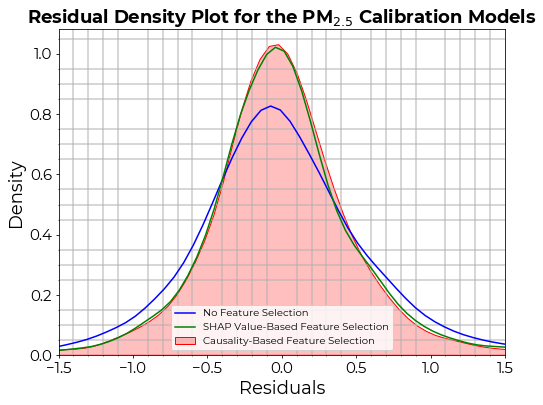

In [15]:
#Generate residual plots
residuals1 = y_test - y_pred_test_full
residuals2 = y_test - y_pred_test_shap
residuals3 = y_test - y_pred_test_caus


plt.figure(figsize=(8, 6))
sns.kdeplot(residuals1, fill=False, label='No Feature Selection', color='blue')
sns.kdeplot(residuals2, fill=False, label='SHAP Value-Based Feature Selection', color='green')
sns.kdeplot(residuals3, fill=True, label='Causality-Based Feature Selection', color='red')
plt.xlim(-1.5, 1.5)


plt.title('Residual Density Plot for the PM$_{2.5}$ Calibration Models')
plt.xlabel('Residuals')
plt.grid(False)
plt.legend(prop={'size': 10})
plt.show()